# **ETL**

## Objectives

* Extract data from imageset, process and transform it, load it ready for use in dashboard

## Inputs

* image set downloaded from Kaggle "6 Human Emotions for image classification"

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Import Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import base64
import os

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Eddie\\Documents\\CodeInstitute Workspace\\Capstone Project\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
if os.path.basename(current_dir).lower() == "jupyter_notebooks":
    os.chdir(os.path.dirname(current_dir))
    print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Eddie\\Documents\\CodeInstitute Workspace\\Capstone Project'

# Extract the images into dataframe



Load the images

In [5]:
# Load an image from file
def load_images(folder):
    subfolders = [element for element in os.listdir(folder) if os.path.isdir(os.path.join(folder, element))]
    collection = []
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder, subfolder)
        for filename in os.listdir(subfolder_path):
            img = cv2.imread(os.path.join(subfolder_path,filename))
            if img is not None:
                # compute luminance (convert BGR to greyscale then take mean)
                grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                luminance = float(np.mean(grey))
                contrast = float(np.std(grey))
                record = {
                    'subfolder': subfolder,
                    'image': img,
                    'grey_image': grey,
                    'luminance': luminance,
                    'contrast': contrast,
                }
                collection.append(record)
    return collection

collection = load_images('./Data/Raw')

df = pd.DataFrame(collection)



Check the data

In [6]:
#check type of image data
type(df.iat[0, 1])

#check dataframe by type of subfolder
df['subfolder'].value_counts()

subfolder
happy      230
sad        224
anger      214
disgust    201
pain       168
fear       163
Name: count, dtype: int64

---

# Resizing + Padding

CNN requires image datasets of the same size. Versions of the dataframe that have images a) resized b) padded c) resized + padded will be created

In [7]:
# Create three derived DataFrames with images adjusted to (maxHeight, maxWidth)
# 1) resize (stretch to exact size)
# 2) pad (center pad to exact size)
# 3) resize (preserve aspect) then pad to exact size

# rely on existing imports and variables (cv2, np, pd, df, maxWidth, maxHeight)

def resize(img, th, tw):
    # make sure tw = target_width, th = target_height
    return cv2.resize(img, (tw, th), interpolation=cv2.INTER_CUBIC)

def resize_and_pad(img, th, tw):
    h, w = img.shape[:2]
    # scale to fit inside target (may upscale or downscale) preserving aspect
    if h > th or w > tw:
        scale = min(th / h, tw / w)
        resized = cv2.resize(img, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        scale = min(th / h, tw / w)
        resized = cv2.resize(img, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    h, w = resized.shape[:2]
    # compute padding amounts
    top = th - h
    right = tw - w
    return cv2.copyMakeBorder(resized, top, 0, 0, right,
                              cv2.BORDER_CONSTANT, value=(0, 0, 0))

# Build new DataFrames
resized_padded_images = []
resized_images = []
grey_resized_padded_images = []
grey_resized_images = []

targetHeight = 600
targetWidth = 600

for img in df['image']:
    resized_padded_images.append(resize_and_pad(img, targetHeight, targetWidth))
    resized_images.append(resize(img, targetHeight, targetWidth))

for grey_img in df['grey_image']:
    grey_resized_padded_images.append(resize_and_pad(grey_img, targetHeight, targetWidth))
    grey_resized_images.append(resize(grey_img, targetHeight, targetWidth))

df_resized_padded = df.copy()
df_resized_padded['image'] = resized_padded_images
df_resized_padded['grey_image'] = grey_resized_padded_images
 
df_resized = df.copy()
df_resized['image'] = resized_images
df_resized['grey_image'] = grey_resized_images
# Now have three dataframes: df, df_resized, df_resized_padded

Text(0.5, 1.0, 'Resized and Padded Grey')

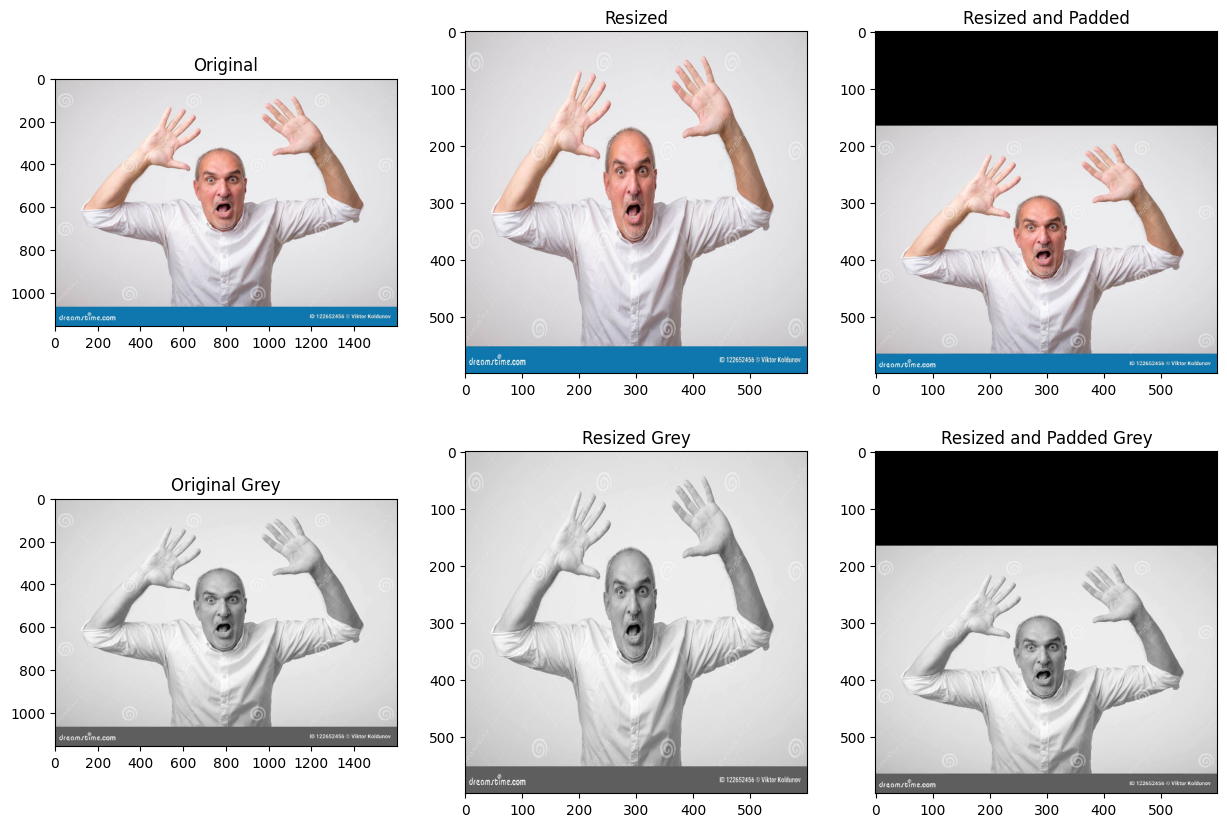

In [8]:
#show sample images from each dataframe for verification
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].imshow(cv2.cvtColor(df['image'][0], cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original')
axs[0, 1].imshow(cv2.cvtColor(df_resized['image'][0], cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Resized')
axs[0, 2].imshow(cv2.cvtColor(df_resized_padded['image'][0], cv2.COLOR_BGR2RGB))
axs[0, 2].set_title('Resized and Padded')
axs[1, 0].imshow(df['grey_image'][0], cmap='grey')
axs[1, 0].set_title('Original Grey')
axs[1, 1].imshow(df_resized['grey_image'][0], cmap='grey')
axs[1, 1].set_title('Resized Grey')
axs[1, 2].imshow(df_resized_padded['grey_image'][0], cmap='grey')
axs[1, 2].set_title('Resized and Padded Grey')

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Loading - Export Data to CSV and image files

* The data is now loaded into appropriate formats for the next notebook for visualisation and analysis

In [13]:
#export images from dataframe into folder structure
os.makedirs('./Data/Processed/Resized', exist_ok=True)
os.makedirs('./Data/Processed/Resized+Padded', exist_ok=True)

df_resized['image_path'] = pd.Series(dtype=str)
df_resized['grey_image_path'] = pd.Series(dtype=str)

for index, row in df_resized.iterrows():
    subfolder = row['subfolder']
    img = row['image']
    grey_img = row['grey_image']
    colour_output_path = os.path.join('./Data/Processed/Resized', f'image_{index}.png')
    cv2.imwrite(colour_output_path, img)
    df_resized.at[index, 'image_path'] = colour_output_path
    grey_output_path = os.path.join('./Data/Processed/Resized', f'grey_image_{index}.png')
    cv2.imwrite(grey_output_path, grey_img)
    df_resized.at[index, 'grey_image_path'] = grey_output_path

for index, row in df_resized_padded.iterrows():
    subfolder = row['subfolder']
    img = row['image']
    grey_img = row['grey_image']
    colour_output_path = os.path.join('./Data/Processed/Resized+Padded', f'image_{index}.png')
    cv2.imwrite(colour_output_path, img)
    df_resized_padded.at[index, 'image_path'] = colour_output_path
    grey_output_path = os.path.join('./Data/Processed/Resized+Padded', f'grey_image_{index}.png')
    cv2.imwrite(grey_output_path, grey_img)
    df_resized_padded.at[index, 'grey_image_path'] = grey_output_path

In [10]:
df_resized.head()

,subfolder,image,grey_image,luminance,contrast,image_path,grey_image_path
0,anger,"[[[204, 203, 205], [197, 196, 198], [195, 194,...","[[204, 197, 195, 197, 197, 197, 198, 198, 198,...",202.218752,42.869499,./Data/Processed/Resized\image_0.png,./Data/Processed/Resized\grey_image_0.png
1,anger,"[[[251, 251, 251], [251, 251, 251], [252, 252,...","[[251, 251, 252, 252, 252, 252, 252, 252, 253,...",134.196622,101.303135,./Data/Processed/Resized\image_1.png,./Data/Processed/Resized\grey_image_1.png
2,anger,"[[[8, 44, 20], [9, 45, 21], [13, 53, 26], [15,...","[[33, 34, 40, 44, 47, 52, 55, 57, 59, 61, 63, ...",109.144209,51.433215,./Data/Processed/Resized\image_2.png,./Data/Processed/Resized\grey_image_2.png
3,anger,"[[[209, 199, 182], [209, 199, 182], [210, 200,...","[[195, 195, 196, 196, 196, 197, 197, 197, 198,...",140.261702,89.338355,./Data/Processed/Resized\image_3.png,./Data/Processed/Resized\grey_image_3.png
4,anger,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",143.852701,81.434234,./Data/Processed/Resized\image_4.png,./Data/Processed/Resized\grey_image_4.png


In [14]:
'''

def _encode_image_to_base64(img):
    if not isinstance(img, np.ndarray):
        return img
    # encode image (works for greyscale or color arrays)
    ok, buf = cv2.imencode('.png', img)
    if not ok:
        return None
    return base64.b64encode(buf.tobytes()).decode('ascii')

def _prepare_df_for_csv(df):
    df_out = df.copy()
    df_out['image'] = df_out['image'].apply(_encode_image_to_base64)
    df_out['grey_image'] = df_out['grey_image'].apply(_encode_image_to_base64)
    return df_out

# prepare and write CSVs (images encoded as base64 PNG strings; shapes kept in separate columns)
df_resized_csv = _prepare_df_for_csv(df_resized)
df_resized_padded_csv = _prepare_df_for_csv(df_resized_padded)

df_resized_csv.to_csv(os.path.join('Data','Processed','df_resized.csv'), index=False)
df_resized_padded_csv.to_csv(os.path.join('Data', 'Processed','df_resized_padded.csv'), index=False)

print("Wrote df_resized.csv and df_resized_padded.csv (images encoded as base64 PNG).")

'''

#remove columns for image data and save dataframes as CSVs with image paths instead
df_resized_csv = df_resized.drop(columns=['image', 'grey_image'])
df_resized_padded_csv = df_resized_padded.drop(columns=['image', 'grey_image'])
df_resized_csv.to_csv(os.path.join('Data','Processed','df_resized.csv'), index=False)
df_resized_padded_csv.to_csv(os.path.join('Data', 'Processed','df_resized_padded.csv'), index=False)

In [15]:
df_resized_csv.head()

,subfolder,luminance,contrast,image_path,grey_image_path
0,anger,202.218752,42.869499,./Data/Processed/Resized\image_0.png,./Data/Processed/Resized\grey_image_0.png
1,anger,134.196622,101.303135,./Data/Processed/Resized\image_1.png,./Data/Processed/Resized\grey_image_1.png
2,anger,109.144209,51.433215,./Data/Processed/Resized\image_2.png,./Data/Processed/Resized\grey_image_2.png
3,anger,140.261702,89.338355,./Data/Processed/Resized\image_3.png,./Data/Processed/Resized\grey_image_3.png
4,anger,143.852701,81.434234,./Data/Processed/Resized\image_4.png,./Data/Processed/Resized\grey_image_4.png
